In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import baltic as bt
from scipy import stats, optimize
from math import ceil

In [2]:
######  CONFIG  #####

# Pull pre-computed clade frequencies
dataset_name = 'SEAsia'
out_path = '../../../data/titer-model/frequencies/'
frequency_path = '../../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

all_branch_effects_tree = '../../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json'
interserotype_branch_effects_tree = '../../../data/titer-model/interserotype-branch-effects/jsons/dengue_all_tree.json'
tree_path = all_branch_effects_tree

uniform_cTiter_clades = [4, 33, 117, 495, 975, 980, 996, 1017, 1020, 1033, 1089, 
                         1386, 1395, 1454, 1588, 1594, 1860, 2027, 2037, 2119, 
                         2167, 2173, 2185, 2230, 2238, 2588]

serotype_clades = [1859,1,1385,974]
genotype_clades = [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638]

date_range = (1970., 2015.)
years_back = 5
years_forward = 5

frequencies = pd.read_csv(frequency_path, index_col=0)
frequencies.rename(columns={i:int(i) for i in frequencies.columns.values}, inplace=True)
frequencies = frequencies.loc[(frequencies.index >= date_range[0]) & (frequencies.index <= date_range[1])]

In [3]:
##### TIMEPOINTS PARSING #####
#  pivots = augur jargon for time points; used here for consistency across codebase

pivots = frequencies.index.tolist()
n_years = int(pivots[-1]) - int(pivots[0])
ppy = len(pivots)/n_years # pivots per year

pivots_back = years_back*ppy
pivots_forward = years_forward*ppy

# pivots with enough data before to infer population exposure AND enough data after to test prediction
informative_pivots = pivots[pivots_back:-1*pivots_forward] 
informative_date_range = (informative_pivots[0], informative_pivots[-1])

In [4]:
#####   INPUT   #####
def get_delta_frequencies(pivots, pivots_forward, informative_date_range, frequencies):
    valid_start = pivots[:-1*pivots_forward] # enough data going forward
    valid_end = pivots[pivots_forward:] 
    delta_t = zip(valid_start, valid_end) 
    delta_f = { i: [frequencies[i][end] - frequencies[i][start] for (start, end) in delta_t] for i in frequencies.columns.values}
    delta_f = pd.DataFrame(delta_f, index=valid_start)
    return delta_f.loc[(delta_f.index >= informative_date_range[0]) & (delta_f.index <= informative_date_range[-1])]

delta_frequencies = get_delta_frequencies(pivots, pivots_forward, informative_date_range, frequencies)

titer_tree = bt.loadJSON(tree_path, json_translation={'name': 'strain', 'height': 'xvalue'})
clade_lookup = { int(k.traits['clade']) : k for k in titer_tree.nodes}
dTiters = {}

def get_dTiter(clade1, clade2, clade_lookup=clade_lookup, dTiters=dTiters):
    key = tuple(sorted([clade1, clade2]))

    if key in dTiters:
        return dTiters[key]

    elif clade1 == clade2:
        dTiter = 0.

    else:
        k1, k2 = clade_lookup[clade1], clade_lookup[clade2]
        k1_trace = []
        k2_trace = []
        k = k1 ## Trace from the node 1 to the root (in order)
        while k.index != 'Root':
            k1_trace.append(k)
            k = k.parent
        k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
        while k not in k1_trace:
            k2_trace.append(k)
            k = k.parent
        else:
            mrca = k
        shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
        k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
        total_trace = []
        total_trace += shared_k1_trace
        total_trace += k2_trace

        dTiter = sum([k.traits['dTiter'] for k in total_trace])

    dTiters[key] = dTiter
    
    return dTiter


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [5]:
#### Calculate cumulative exposure to genotype i at the START of each season we have data for
def calc_population_exposure(i, gamma, sigma, all_clades,
                             pivots=pivots, pivots_back=pivots_back, 
                             informative_pivots = informative_pivots, max_years_back=years_back, 
                             ppy=ppy, informative_date_range=informative_date_range,
                             frequencies=frequencies):
        
    population_exposure = []

    starting_pivots = informative_pivots
    for starting_p in starting_pivots: # each starting season of interest
        p_idx = pivots.index(starting_p)
        previous_pivots = pivots[p_idx - pivots_back:p_idx]
        
        cumulative_exposure = 0.
        
        for idx, previous_p in enumerate(previous_pivots, start=0):
            yrs_back = float(idx)/float(ppy)
            waning = max(gamma*yrs_back + 1, 0.)

            for j in all_clades: # for each genotype
                D_ij = get_dTiter(i,j)
                C_D_ij = 1 + sigma*D_ij # we don't precompute all dTiter values, so check sanity check the sigma value on the fly for each dTiter value
#                 assert float(C_D_ij) >= float(0.0) and float(C_D_ij) <= float(1.0), 'ERROR: dTiter value %.2f, between clades %d and %d, yielded an invalid C(ij) value of %.2f'%(D_ij, i, j, C_D_ij)
                
                j_frequency = frequencies[j][previous_p]
                
                exposure = j_frequency * C_D_ij * waning
                cumulative_exposure += exposure
                
        population_exposure.append(cumulative_exposure)
        
    return population_exposure

LinregressResult(slope=-0.0044434915480637332, intercept=0.02817925021477383, rvalue=-0.093376393051949669, pvalue=0.00023095684680006693, stderr=0.001203815452096634)


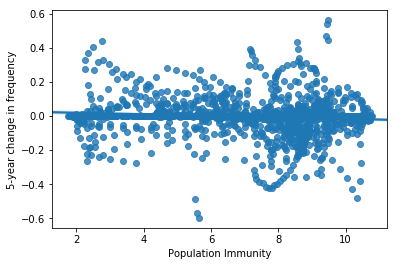

In [9]:
# genotypes that have reached at least 10% frequency at some point
antigenic_clades = genotype_clades
informative_clades = [i for i in antigenic_clades if frequencies[i].max() >= 0.1]

antigenic_clade_exposure = {i:pd.DataFrame(calc_population_exposure(i, -0.125, -0.15, antigenic_clades), 
                                           index=informative_pivots, columns=['population_exposure'])
                            for i in informative_clades}

pooled_exposure = []
pooled_delta_f = []

for i, exposure in antigenic_clade_exposure.items():
    valid_pivots = delta_frequencies.index
    exposure = exposure.loc[exposure.index.isin(valid_pivots)]
    exposure['delta_frequency'] = delta_frequencies[i]
    antigenic_clade_exposure[i] = exposure

    pooled_exposure += exposure['population_exposure'].tolist()
    pooled_delta_f += exposure['delta_frequency'].tolist()

pooled_fit = stats.linregress(pooled_exposure, pooled_delta_f)
print pooled_fit
sns.regplot(pd.Series(pooled_exposure), pd.Series(pooled_delta_f))
plt.xlabel('Population Immunity')
plt.ylabel('5-year change in frequency')
plt.show()

In [ ]:
####    PLOT   #####
def plot_exposure_delta_frequencies(i, ax, population_exposure):
    sns.regplot('population_exposure', 'delta_frequency', data=population_exposure[i], ax=ax)
    ax.set_title(i)
    ax.set_xlabel('Population immunity')
    ax.set_ylabel('%d-yr change in frequency'%years_forward)

sns.set(style='whitegrid', font_scale=1.1, palette='pastel')
n_j_vals = len(antigenic_clade_exposure.keys())
ncols = 4
nrows = int(ceil(n_j_vals/ncols))

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, figsize=(12,8), sharey=True, sharex=True)
for j, ax in zip(sorted(antigenic_clade_exposure.keys()), axes.flatten()):
    plot_exposure_delta_frequencies(j, ax, antigenic_clade_exposure)
plt.tight_layout()
plt.show()

In [ ]:
def predict_all_trajectories((gamma, sigma)):
    pooled_exposure = []
    pooled_delta_f = []

    informative_clades = [c for c in antigenic_clades if frequencies[c].max() >= 0.1]
    for i in informative_clades:
        pooled_exposure += calc_population_exposure(i, gamma, sigma, antigenic_clades)
        pooled_delta_f += delta_frequencies[i].tolist()

    slope, intercept, r_value, p_value, std_err =  stats.linregress(pooled_exposure, pooled_delta_f)
    return -1.*r_value


optimized_parameters = optimize.minimize(fun=predict_all_trajectories, x0=[-0.125, -0.15],
                                         bounds=[(-1.0, -0.1), (-0.2, -0.02)],tol=1e-3,options={'maxiter': 150})

print optimized_parameters